# EDA of StatsBomb dataset


- Load and explore the hierarchical structure (competitions → matches → events/lineups)
- Understand available competitions, seasons, and match coverage
- Inspect event types and their attributes

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from collections import Counter

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Define data paths
DATA_PATH = Path('open-data/data')
COMPETITIONS_FILE = DATA_PATH / 'competitions.json'
MATCHES_PATH = DATA_PATH / 'matches'
EVENTS_PATH = DATA_PATH / 'events'
LINEUPS_PATH = DATA_PATH / 'lineups'

# Load competitions data
with open(COMPETITIONS_FILE, 'r') as f:
    competitions = json.load(f)

competitions_df = pd.DataFrame(competitions)

## Competition Coverage Overview

Show number of matches available per competition and season


Total matches loaded: 3464


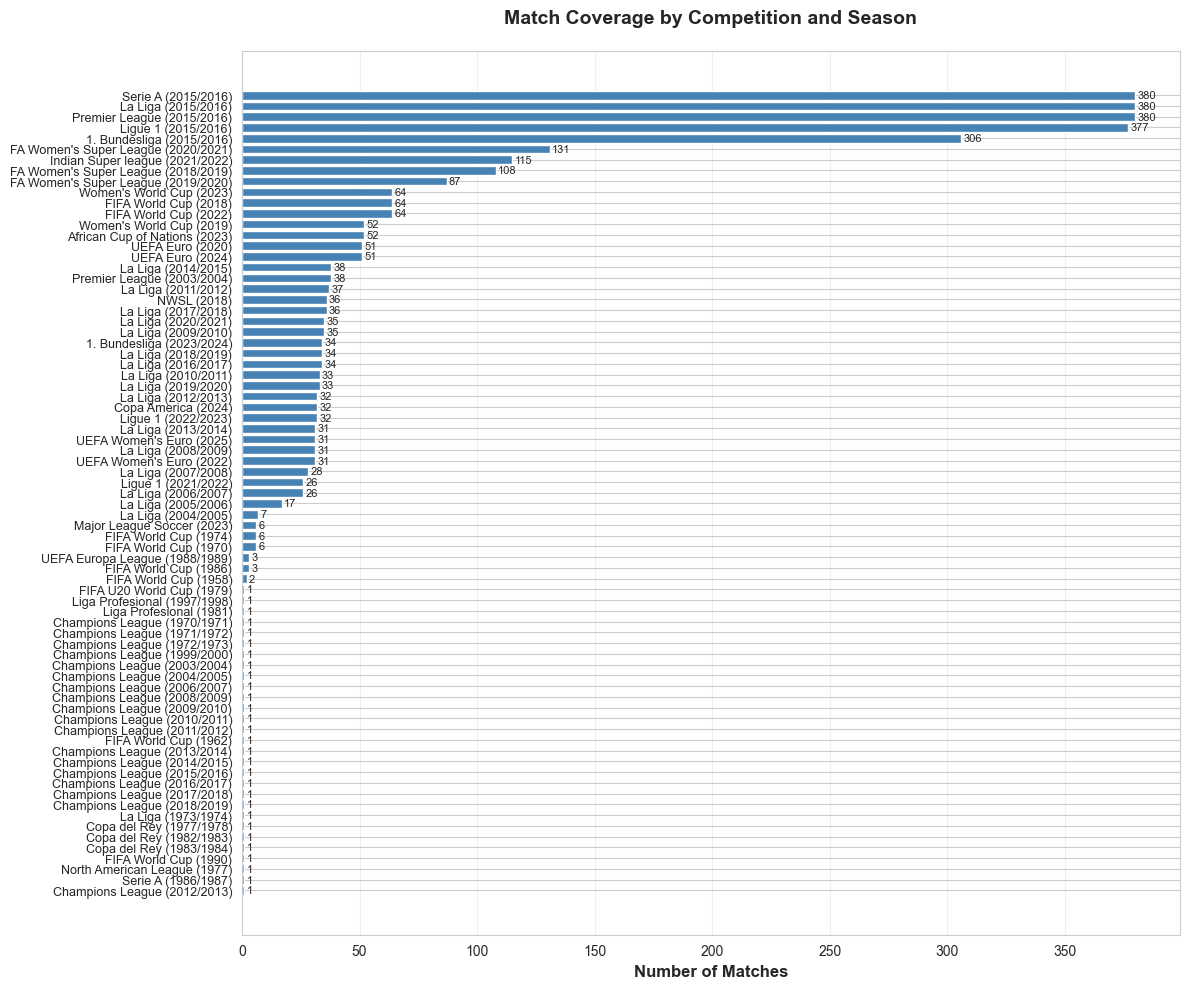


Top 5 competitions by match count:
competition_name season_name  match_count
  Premier League   2015/2016          380
         La Liga   2015/2016          380
         Serie A   2015/2016          380
         Ligue 1   2015/2016          377
   1. Bundesliga   2015/2016          306


In [ ]:
# Competition Coverage Overview
# Load all matches to count them per competition/season
all_matches = []

for comp_row in competitions:
    comp_id = comp_row['competition_id']
    season_id = comp_row['season_id']
    match_file = MATCHES_PATH / str(comp_id) / f"{season_id}.json"
    
    if match_file.exists():
        with open(match_file, 'r') as f:
            matches = json.load(f)
            for match in matches:
                all_matches.append({
                    'competition_id': comp_id,
                    'competition_name': comp_row['competition_name'],
                    'season_id': season_id,
                    'season_name': comp_row['season_name'],
                    'match_id': match['match_id']
                })

matches_df = pd.DataFrame(all_matches)
print(f"Total matches loaded: {len(matches_df)}")

# Create visualization
comp_match_counts = matches_df.groupby(['competition_name', 'season_name']).size().reset_index(name='match_count')
comp_match_counts = comp_match_counts.sort_values('match_count', ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))
y_labels = [f"{row['competition_name']} ({row['season_name']})" 
            for _, row in comp_match_counts.iterrows()]

bars = ax.barh(range(len(comp_match_counts)), comp_match_counts['match_count'], color='steelblue')
ax.set_yticks(range(len(comp_match_counts)))
ax.set_yticklabels(y_labels, fontsize=9)
ax.set_xlabel('Number of Matches', fontsize=12, fontweight='bold')
ax.set_title('Match Coverage by Competition and Season', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, comp_match_counts['match_count'])):
    ax.text(count + 1, i, str(count), va='center', fontsize=8)

plt.tight_layout()
plt.show()

print("\nTop 5 competitions by match count:")
print(comp_match_counts.nlargest(5, 'match_count')[['competition_name', 'season_name', 'match_count']].to_string(index=False))

## Event Type Distribution

What types of actions are most common in football (passes vs shots vs duels, etc.)

In [12]:
# Load sample events to analyze event types
# Let's sample matches from the most data-rich competition
sample_match_ids = matches_df['match_id'].sample(min(50, len(matches_df)), random_state=42).tolist()

all_events = []

for match_id in sample_match_ids:
    event_file = EVENTS_PATH / f"{match_id}.json"
    if event_file.exists():
        with open(event_file, 'r') as f:
            events = json.load(f)
            all_events.extend(events)

events_df = pd.DataFrame(all_events)
events_df[['type', 'minute', 'second', 'team', 'player']].head(10)

,type,minute,second,team,player
0,"{'id': 35, 'name': 'Starting XI'}",0,0,"{'id': 226, 'name': 'Hellas Verona'}",NaN
1,"{'id': 35, 'name': 'Starting XI'}",0,0,"{'id': 290, 'name': 'Empoli'}",NaN
2,"{'id': 18, 'name': 'Half Start'}",0,0,"{'id': 226, 'name': 'Hellas Verona'}",NaN
3,"{'id': 18, 'name': 'Half Start'}",0,0,"{'id': 290, 'name': 'Empoli'}",NaN
4,"{'id': 30, 'name': 'Pass'}",0,0,"{'id': 290, 'name': 'Empoli'}","{'id': 7150, 'name': 'Riccardo Saponara'}"
5,"{'id': 42, 'name': 'Ball Receipt*'}",0,1,"{'id': 290, 'name': 'Empoli'}","{'id': 17520, 'name': 'Federico Barba'}"
6,"{'id': 43, 'name': 'Carry'}",0,1,"{'id': 290, 'name': 'Empoli'}","{'id': 17520, 'name': 'Federico Barba'}"
7,"{'id': 30, 'name': 'Pass'}",0,1,"{'id': 290, 'name': 'Empoli'}","{'id': 17520, 'name': 'Federico Barba'}"
8,"{'id': 42, 'name': 'Ball Receipt*'}",0,2,"{'id': 290, 'name': 'Empoli'}","{'id': 8664, 'name': 'Andrea Costa'}"
9,"{'id': 43, 'name': 'Carry'}",0,2,"{'id': 290, 'name': 'Empoli'}","{'id': 8664, 'name': 'Andrea Costa'}"


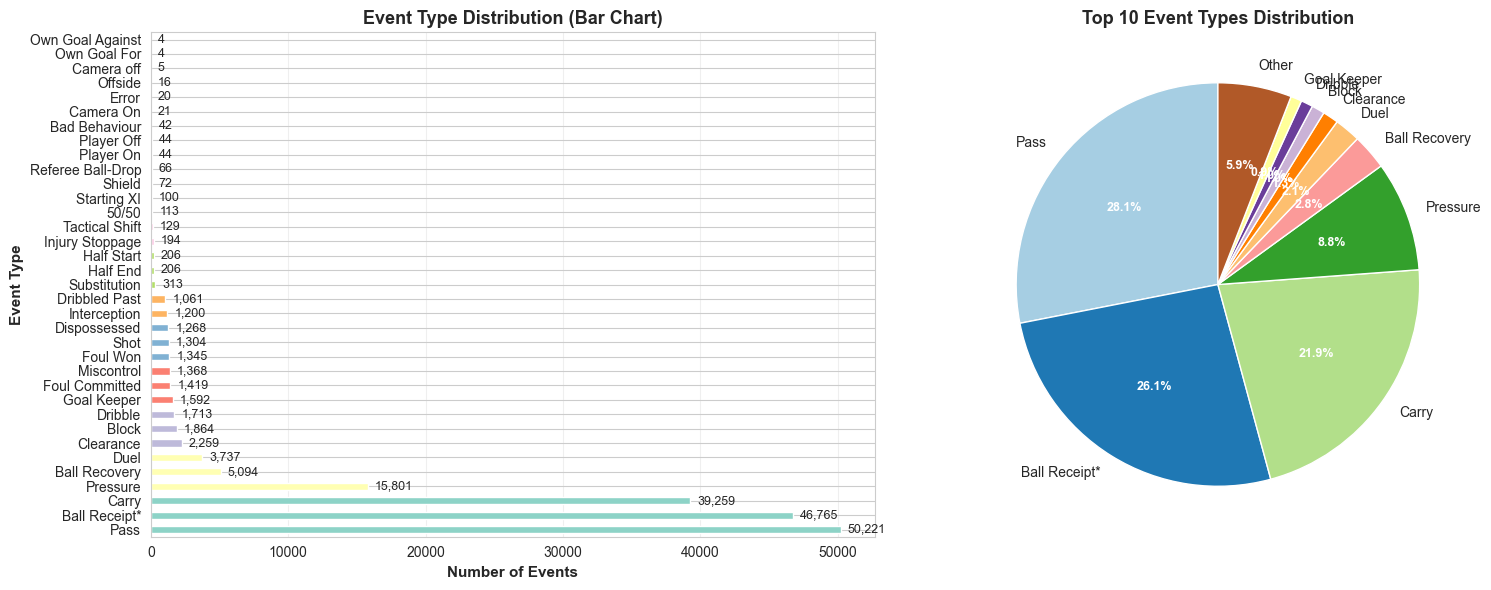

In [ ]:
# Event Type Distribution
# Extract event type names
event_types = events_df['type'].apply(lambda x: x['name'] if isinstance(x, dict) else x)
event_counts = event_types.value_counts()

# Create subplot with bar chart and pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
colors = plt.cm.Set3(np.linspace(0, 1, len(event_counts)))
event_counts.plot(kind='barh', ax=ax1, color=colors)
ax1.set_xlabel('Number of Events', fontsize=11, fontweight='bold')
ax1.set_ylabel('Event Type', fontsize=11, fontweight='bold')
ax1.set_title('Event Type Distribution (Bar Chart)', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(event_counts.values):
    ax1.text(v + max(event_counts)*0.01, i, f'{v:,}', va='center', fontsize=9)

# Pie chart - top 10 event types
top_events = event_counts.head(10)
other_count = event_counts.iloc[10:].sum() if len(event_counts) > 10 else 0

if other_count > 0:
    top_events_with_other = pd.concat([top_events, pd.Series({'Other': other_count})])
else:
    top_events_with_other = top_events

colors_pie = plt.cm.Paired(np.linspace(0, 1, len(top_events_with_other)))
wedges, texts, autotexts = ax2.pie(top_events_with_other, 
                                     labels=top_events_with_other.index,
                                     autopct='%1.1f%%',
                                     colors=colors_pie,
                                     startangle=90)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(9)
    autotext.set_fontweight('bold')

ax2.set_title('Top 10 Event Types Distribution', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

## Shot Analysis - Location Heatmap

Identify high-value shooting zones, compare shot locations for goals vs non-goals

Total shot events: 1304
Shots with location data: 1304


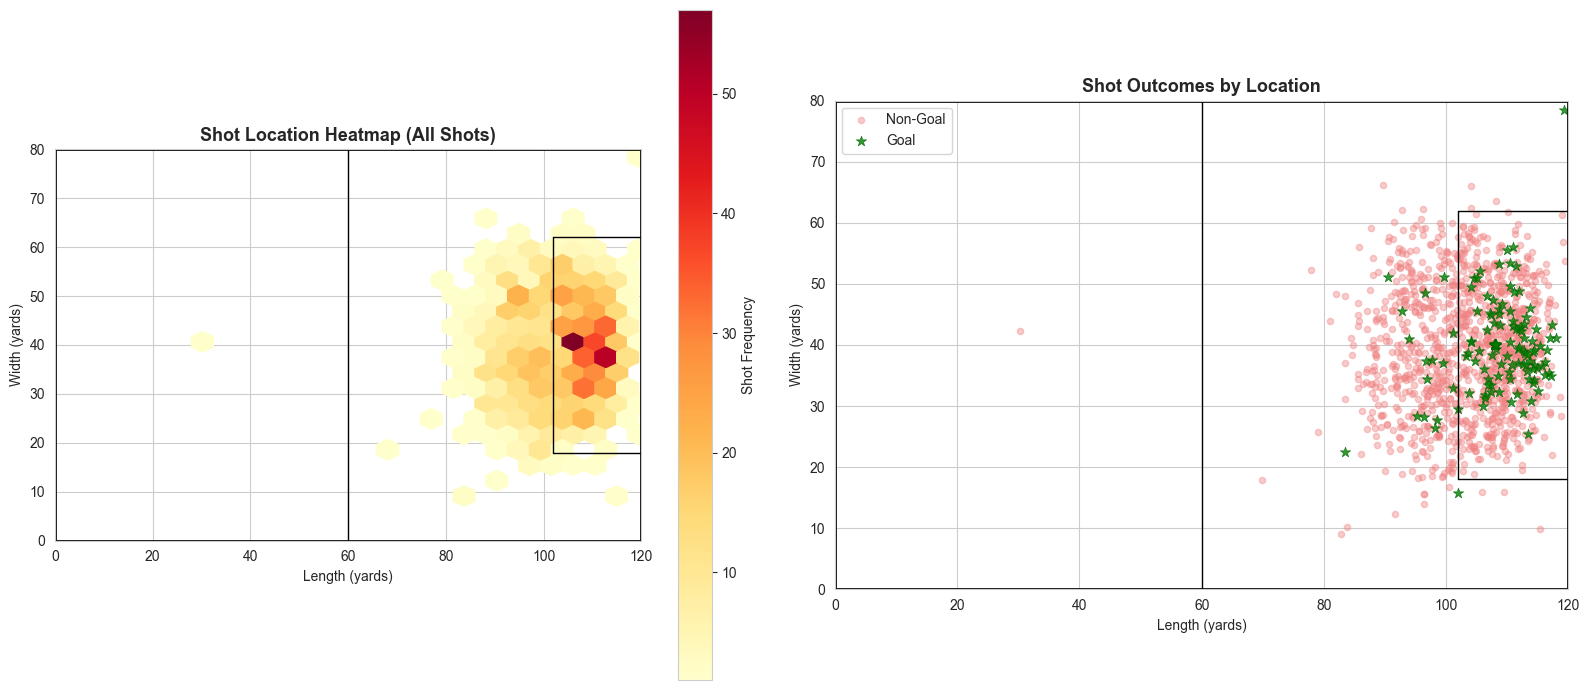


Shot Statistics:
Total goals: 135
Total non-goals: 1169
Conversion rate: 10.4%

Average shot location (x, y):
All shots: (103.7, 39.3)
Goals only: (108.4, 39.8)


In [5]:
# Visualization 3: Shot Analysis - Location Heatmap
# Filter shot events
shot_events = events_df[events_df['type'].apply(
    lambda x: x.get('name', '') == 'Shot' if isinstance(x, dict) else str(x) == 'Shot'
)].copy()

print(f"Total shot events: {len(shot_events)}")

# Extract location data
shot_locations = []
for idx, row in shot_events.iterrows():
    if 'location' in row and row['location'] is not None:
        if isinstance(row['location'], list) and len(row['location']) >= 2:
            x, y = row['location'][0], row['location'][1]
            
            # Determine if it was a goal
            is_goal = False
            if 'shot' in row and isinstance(row['shot'], dict):
                outcome = row['shot'].get('outcome', {})
                if isinstance(outcome, dict):
                    is_goal = outcome.get('name', '') == 'Goal'
            
            shot_locations.append({'x': x, 'y': y, 'is_goal': is_goal})

shot_loc_df = pd.DataFrame(shot_locations)
print(f"Shots with location data: {len(shot_loc_df)}")

if len(shot_loc_df) > 0:
    # Create pitch visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: All shots heatmap
    ax1 = axes[0]
    ax1.set_xlim(0, 120)
    ax1.set_ylim(0, 80)
    ax1.set_aspect('equal')
    
    # Draw pitch outline
    ax1.plot([0, 0], [0, 80], 'k-', linewidth=2)
    ax1.plot([0, 120], [80, 80], 'k-', linewidth=2)
    ax1.plot([120, 120], [80, 0], 'k-', linewidth=2)
    ax1.plot([120, 0], [0, 0], 'k-', linewidth=2)
    ax1.plot([60, 60], [0, 80], 'k-', linewidth=1)
    
    # Penalty box
    ax1.plot([102, 102], [18, 62], 'k-', linewidth=1)
    ax1.plot([102, 120], [18, 18], 'k-', linewidth=1)
    ax1.plot([102, 120], [62, 62], 'k-', linewidth=1)
    
    # Create hexbin plot
    hexbin = ax1.hexbin(shot_loc_df['x'], shot_loc_df['y'], gridsize=20, cmap='YlOrRd', mincnt=1)
    plt.colorbar(hexbin, ax=ax1, label='Shot Frequency')
    ax1.set_title('Shot Location Heatmap (All Shots)', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Length (yards)', fontsize=10)
    ax1.set_ylabel('Width (yards)', fontsize=10)
    
    # Plot 2: Goals vs Non-Goals
    ax2 = axes[1]
    ax2.set_xlim(0, 120)
    ax2.set_ylim(0, 80)
    ax2.set_aspect('equal')
    
    # Draw pitch outline
    ax2.plot([0, 0], [0, 80], 'k-', linewidth=2)
    ax2.plot([0, 120], [80, 80], 'k-', linewidth=2)
    ax2.plot([120, 120], [80, 0], 'k-', linewidth=2)
    ax2.plot([120, 0], [0, 0], 'k-', linewidth=2)
    ax2.plot([60, 60], [0, 80], 'k-', linewidth=1)
    
    # Penalty box
    ax2.plot([102, 102], [18, 62], 'k-', linewidth=1)
    ax2.plot([102, 120], [18, 18], 'k-', linewidth=1)
    ax2.plot([102, 120], [62, 62], 'k-', linewidth=1)
    
    # Plot goals and non-goals
    non_goals = shot_loc_df[~shot_loc_df['is_goal']]
    goals = shot_loc_df[shot_loc_df['is_goal']]
    
    ax2.scatter(non_goals['x'], non_goals['y'], c='lightcoral', s=20, alpha=0.4, label='Non-Goal')
    ax2.scatter(goals['x'], goals['y'], c='green', s=60, alpha=0.8, marker='*', 
                edgecolors='darkgreen', linewidth=0.5, label='Goal')
    
    ax2.set_title('Shot Outcomes by Location', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Length (yards)', fontsize=10)
    ax2.set_ylabel('Width (yards)', fontsize=10)
    ax2.legend(loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nShot Statistics:")
    print(f"Total goals: {goals.shape[0]}")
    print(f"Total non-goals: {non_goals.shape[0]}")
    print(f"Conversion rate: {(goals.shape[0] / len(shot_loc_df) * 100):.1f}%")
    
    print(f"\nAverage shot location (x, y):")
    print(f"All shots: ({shot_loc_df['x'].mean():.1f}, {shot_loc_df['y'].mean():.1f})")
    if len(goals) > 0:
        print(f"Goals only: ({goals['x'].mean():.1f}, {goals['y'].mean():.1f})")
else:
    print("No shot location data available for visualization.")

## Pass Network Visualization

Show passing connections between players (nodes) and pass frequency (edge weights)


Analyzing match ID: 3879641
Teams: ['Hellas Verona' 'Empoli']
Total passes by Hellas Verona: 595
Passes with recipient data: 545


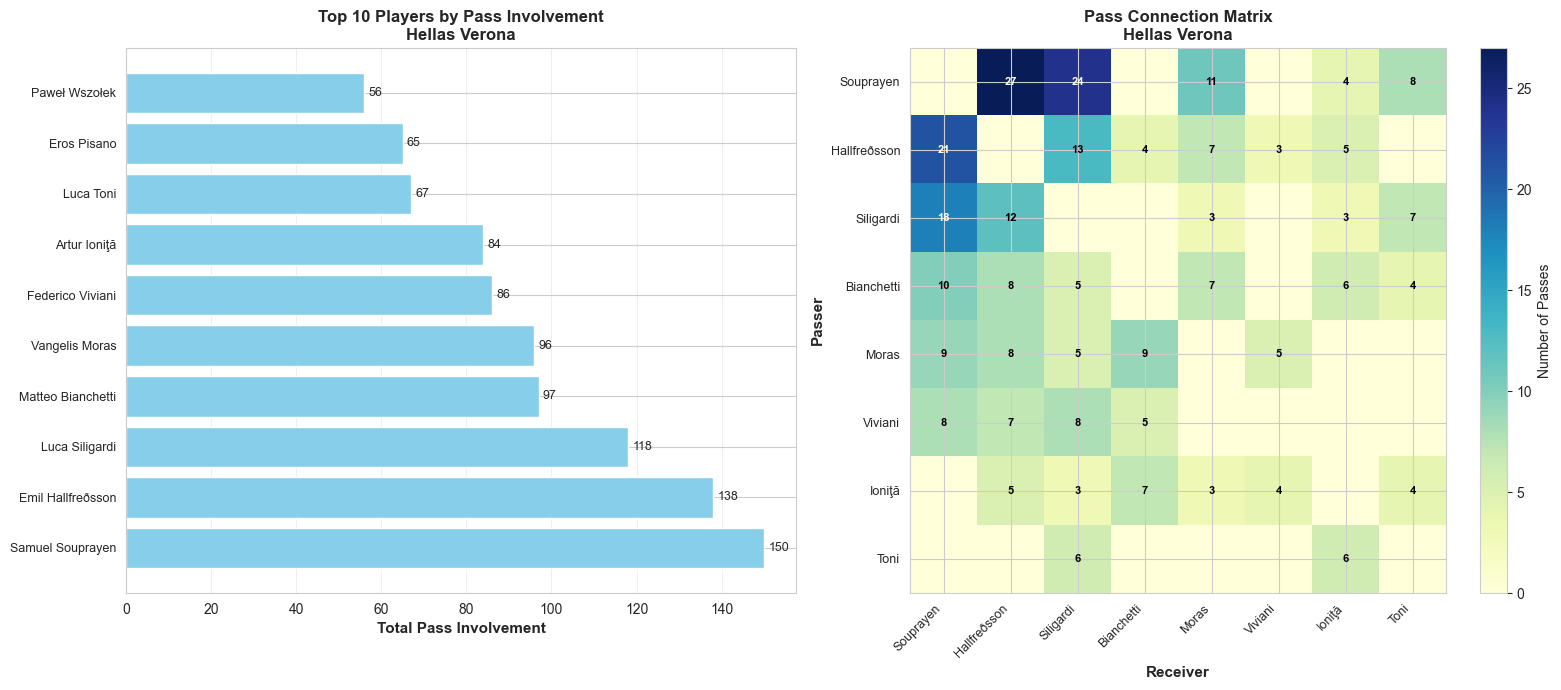

In [ ]:
# Pass Network Visualization
# Filter pass events from a single match for clarity
sample_match_id = sample_match_ids[0]
match_event_file = EVENTS_PATH / f"{sample_match_id}.json"

with open(match_event_file, 'r') as f:
    match_events = json.load(f)

match_events_df = pd.DataFrame(match_events)
print(f"Analyzing match ID: {sample_match_id}")

# Get team names
teams = match_events_df['team'].apply(lambda x: x.get('name', '') if isinstance(x, dict) else str(x)).unique()
print(f"Teams: {teams}")

# Select first team for pass network
team_name = teams[0]
team_events = match_events_df[match_events_df['team'].apply(
    lambda x: x.get('name', '') == team_name if isinstance(x, dict) else False
)]

# Filter passes
passes = team_events[team_events['type'].apply(
    lambda x: x.get('name', '') == 'Pass' if isinstance(x, dict) else False
)].copy()

print(f"Total passes by {team_name}: {len(passes)}")

# Extract passer and receiver information
pass_network = []
for idx, row in passes.iterrows():
    passer = row['player'].get('name', '') if isinstance(row['player'], dict) else ''
    
    # Check for pass recipient
    receiver = None
    if 'pass' in row and isinstance(row['pass'], dict):
        if 'recipient' in row['pass'] and isinstance(row['pass']['recipient'], dict):
            receiver = row['pass']['recipient'].get('name', '')
    
    if passer and receiver:
        pass_network.append({'passer': passer, 'receiver': receiver})

pass_network_df = pd.DataFrame(pass_network)
print(f"Passes with recipient data: {len(pass_network_df)}")

if len(pass_network_df) > 0:
    # Count passes between players
    pass_counts = pass_network_df.groupby(['passer', 'receiver']).size().reset_index(name='count')
    pass_counts = pass_counts[pass_counts['count'] >= 3]  # Filter for clarity
    
    # Calculate player involvement
    player_passes = pass_network_df['passer'].value_counts() + pass_network_df['receiver'].value_counts()
    player_passes = player_passes.fillna(0)
    
    # Create network visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Top passers
    top_passers = player_passes.nlargest(10)
    ax1.barh(range(len(top_passers)), top_passers.values, color='skyblue')
    ax1.set_yticks(range(len(top_passers)))
    ax1.set_yticklabels(top_passers.index, fontsize=9)
    ax1.set_xlabel('Total Pass Involvement', fontsize=11, fontweight='bold')
    ax1.set_title(f'Top 10 Players by Pass Involvement\n{team_name}', fontsize=12, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    for i, v in enumerate(top_passers.values):
        ax1.text(v + 1, i, str(int(v)), va='center', fontsize=9)
    
    # Plot 2: Pass connections matrix (top players)
    top_players = player_passes.nlargest(8).index.tolist()
    
    # Create matrix
    matrix = np.zeros((len(top_players), len(top_players)))
    for _, row in pass_counts.iterrows():
        if row['passer'] in top_players and row['receiver'] in top_players:
            i = top_players.index(row['passer'])
            j = top_players.index(row['receiver'])
            matrix[i, j] = row['count']
    
    im = ax2.imshow(matrix, cmap='YlGnBu', aspect='auto')
    ax2.set_xticks(range(len(top_players)))
    ax2.set_yticks(range(len(top_players)))
    ax2.set_xticklabels([name.split()[-1] for name in top_players], rotation=45, ha='right', fontsize=9)
    ax2.set_yticklabels([name.split()[-1] for name in top_players], fontsize=9)
    ax2.set_xlabel('Receiver', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Passer', fontsize=11, fontweight='bold')
    ax2.set_title(f'Pass Connection Matrix\n{team_name}', fontsize=12, fontweight='bold')
    
    # Add count labels
    for i in range(len(top_players)):
        for j in range(len(top_players)):
            if matrix[i, j] > 0:
                ax2.text(j, i, int(matrix[i, j]), ha='center', va='center', 
                        color='white' if matrix[i, j] > matrix.max()/2 else 'black',
                        fontsize=8, fontweight='bold')
    
    plt.colorbar(im, ax=ax2, label='Number of Passes')
    plt.tight_layout()
    plt.show()

## Match Timeline - Event Density

Identify high-intensity periods, typical scoring times, end-of-half patterns- 

Events in first half: 91676
Events in second half: 81828
Events in extra time: 5365


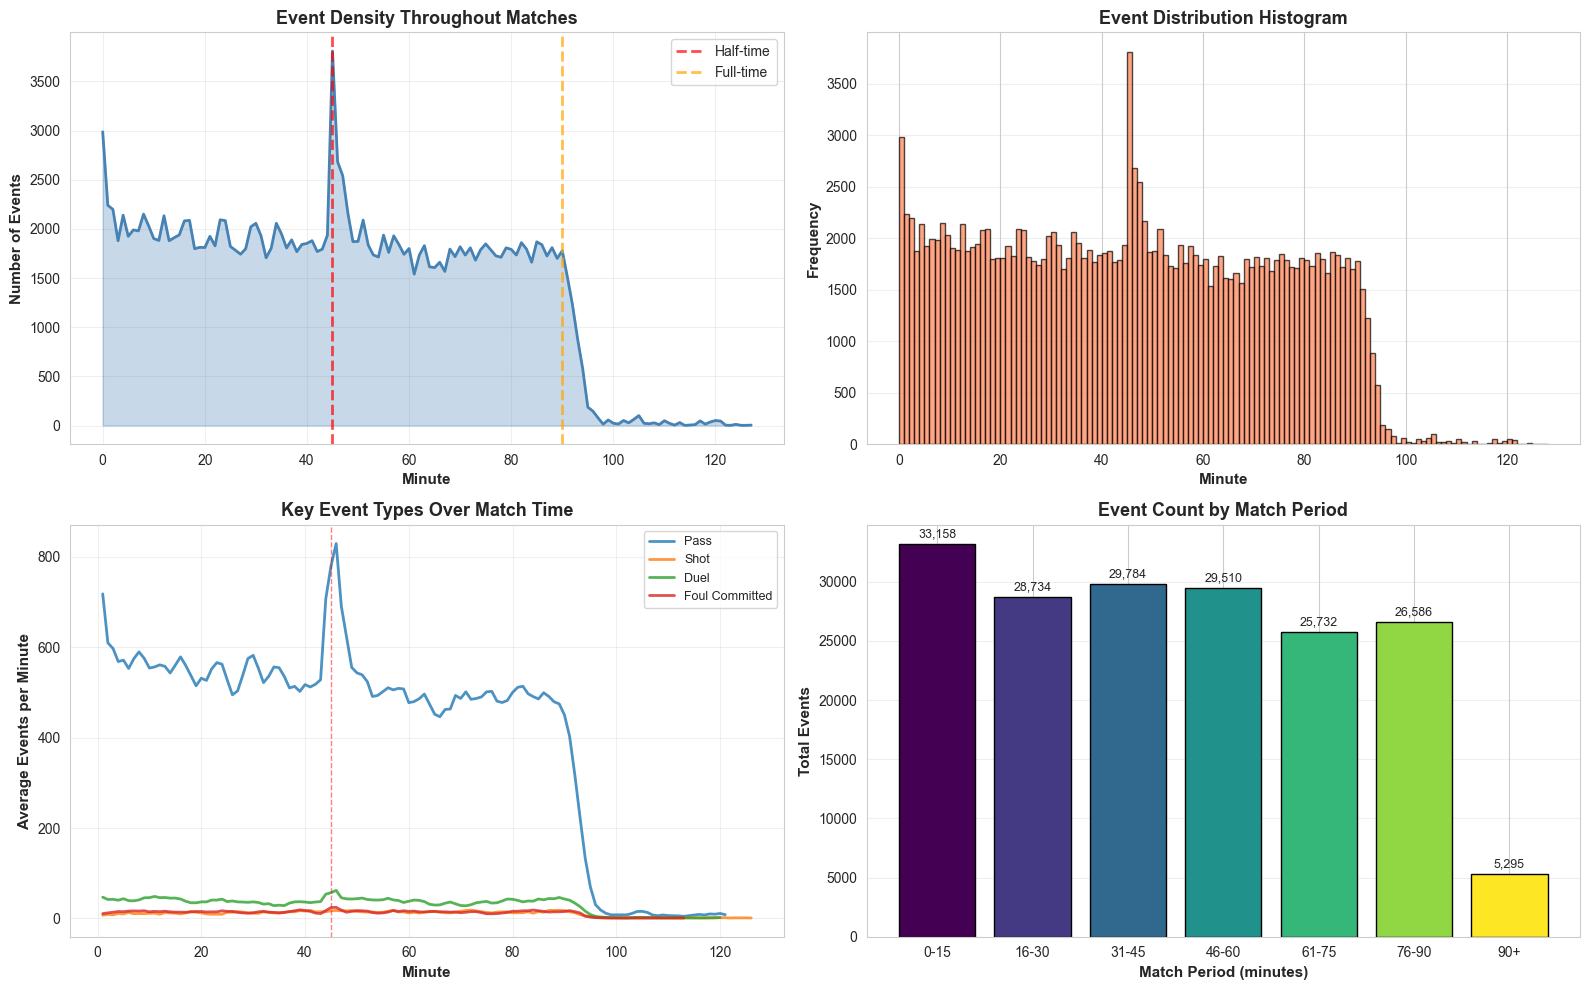

In [ ]:
# Match Timeline - Event Density
# Analyze event density over match time using all loaded events
events_df['minute'] = pd.to_numeric(events_df['minute'], errors='coerce')
events_df = events_df.dropna(subset=['minute'])

# Separate by half
first_half = events_df[events_df['minute'] <= 45]
second_half = events_df[(events_df['minute'] > 45) & (events_df['minute'] <= 90)]
extra_time = events_df[events_df['minute'] > 90]

print(f"Events in first half: {len(first_half)}")
print(f"Events in second half: {len(second_half)}")
print(f"Events in extra time: {len(extra_time)}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Overall event density by minute
ax1 = axes[0, 0]
minute_counts = events_df['minute'].value_counts().sort_index()
ax1.plot(minute_counts.index, minute_counts.values, linewidth=2, color='steelblue')
ax1.fill_between(minute_counts.index, minute_counts.values, alpha=0.3, color='steelblue')
ax1.axvline(x=45, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Half-time')
if len(second_half) > 0:
    ax1.axvline(x=90, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Full-time')
ax1.set_xlabel('Minute', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Events', fontsize=11, fontweight='bold')
ax1.set_title('Event Density Throughout Matches', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.legend()

# Plot 2: Histogram of events per minute bin
ax2 = axes[0, 1]
ax2.hist(events_df['minute'], bins=range(0, int(events_df['minute'].max()) + 2), 
         color='coral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Minute', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Event Distribution Histogram', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Key event types over time
ax3 = axes[1, 0]
event_type_names = events_df['type'].apply(lambda x: x.get('name', '') if isinstance(x, dict) else str(x))
key_events = ['Pass', 'Shot', 'Duel', 'Foul Committed']

for event in key_events:
    event_mask = event_type_names == event
    event_minutes = events_df[event_mask]['minute']
    if len(event_minutes) > 0:
        minute_dist = event_minutes.value_counts().sort_index()
        # Smooth with rolling average
        if len(minute_dist) > 5:
            minute_dist = minute_dist.rolling(window=3, center=True).mean()
        ax3.plot(minute_dist.index, minute_dist.values, linewidth=2, label=event, alpha=0.8)

ax3.set_xlabel('Minute', fontsize=11, fontweight='bold')
ax3.set_ylabel('Average Events per Minute', fontsize=11, fontweight='bold')
ax3.set_title('Key Event Types Over Match Time', fontsize=13, fontweight='bold')
ax3.legend(loc='best', fontsize=9)
ax3.grid(alpha=0.3)
ax3.axvline(x=45, color='red', linestyle='--', linewidth=1, alpha=0.5)

# Plot 4: Event intensity by 15-minute intervals
ax4 = axes[1, 1]
bins = [0, 15, 30, 45, 60, 75, 90, 120]
labels = ['0-15', '16-30', '31-45', '46-60', '61-75', '76-90', '90+']
events_df['period'] = pd.cut(events_df['minute'], bins=bins, labels=labels, include_lowest=True)
period_counts = events_df['period'].value_counts().sort_index()

colors_bar = plt.cm.viridis(np.linspace(0, 1, len(period_counts)))
ax4.bar(range(len(period_counts)), period_counts.values, color=colors_bar, edgecolor='black')
ax4.set_xticks(range(len(period_counts)))
ax4.set_xticklabels(period_counts.index, rotation=0, fontsize=10)
ax4.set_xlabel('Match Period (minutes)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Total Events', fontsize=11, fontweight='bold')
ax4.set_title('Event Count by Match Period', fontsize=13, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(period_counts.values):
    ax4.text(i, v + max(period_counts)*0.01, f'{v:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()